Goal: a scene classification model that classifies an image to one of 6 labels:
- Buildings
- Forests
- Mountains
- Glacier
- Street
- Sea

Dataset: https://www.kaggle.com/datasets/nitishabharathi/scene-classification?resource=download&select=train-scene+classification

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2022-11-22 17:09:08.790475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(seed=123)

## Load data

In [3]:
from PIL import Image

def generate_xy(df):
    X = []
    for i in df['image_name'].values:
        img = Image.open(f'train-scene classification/train/{i}')
        img_arr = np.array(img)
        if img_arr.shape[0] == 150:
            X.append(np.array(img))
        else:
            X.append(np.array(img.resize((150,150))))

    X = np.array(X)
    Y = df['label'].values
    
    return X, Y

In [4]:
labels = ['building','forest','glacier','mountain',
            'sea','street']

In [5]:
samples_df = pd.read_csv('train-scene classification/train.csv')

val_df = samples_df.sample(frac=.2)
test_df = samples_df[~samples_df.index.isin(val_df.index)].sample(frac=.1)
train_df = samples_df[~samples_df.index.isin(val_df.index) & ~samples_df.index.isin(test_df.index)]

In [6]:
train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

17034

In [7]:
samples_df.shape[0]

17034

In [8]:
train_X, train_Y = generate_xy(train_df)
val_X, val_Y = generate_xy(val_df)
test_X, test_Y = generate_xy(test_df)

## Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
classes = samples_df['label'].unique()
classes

array([0, 4, 5, 1, 2, 3])

### Explore image specifics

In [11]:
print(f'total training samples: {train_X.shape[0]}')
print(f'total val samples: {val_X.shape[0]}')
print(f'total test samples: {test_X.shape[0]}')
print(f'image size: {train_X.shape[1:3]}')

total training samples: 12264
total val samples: 3407
total test samples: 1363
image size: (150, 150)


### Check class balance across train/val dataset

#### Whole dataset

<AxesSubplot: xlabel='label', ylabel='counts'>

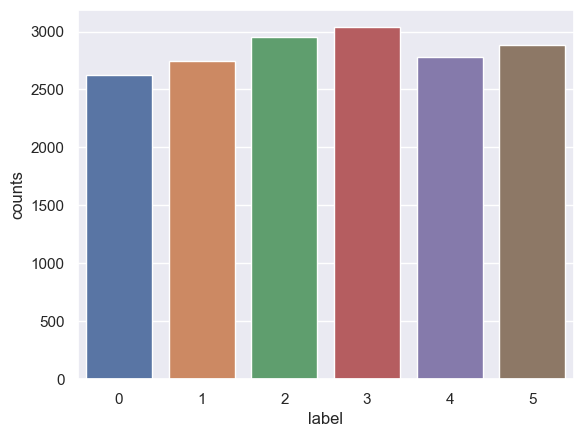

In [12]:
class_counts = samples_df.groupby(by='label').count().reset_index()
class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=class_counts) 

#### Train dataset

<AxesSubplot: xlabel='label', ylabel='counts'>

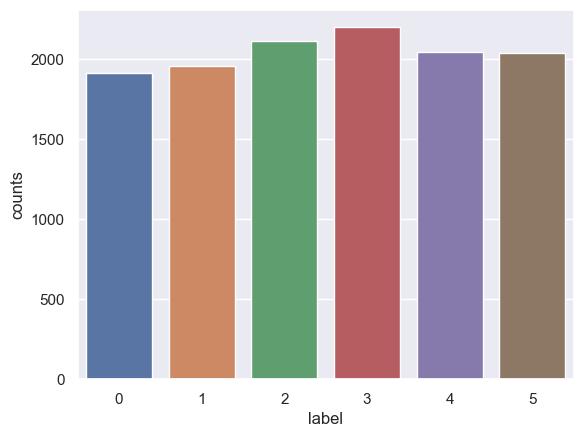

In [13]:
train_class_counts = train_df.groupby(by='label').count().reset_index()
train_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=train_class_counts) 

#### Val dataset

<AxesSubplot: xlabel='label', ylabel='counts'>

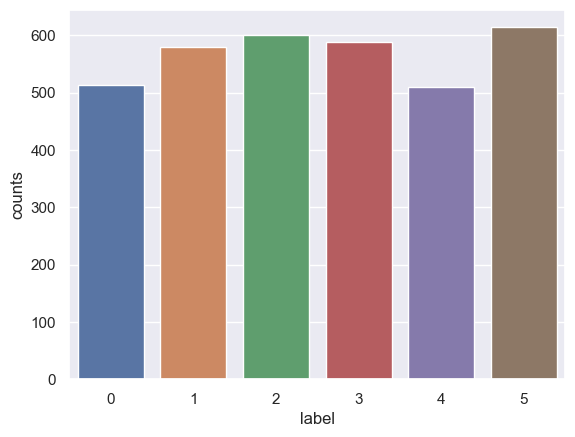

In [14]:
val_class_counts = val_df.groupby(by='label').count().reset_index()
val_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=val_class_counts) 

#### Test dataset

<AxesSubplot: xlabel='label', ylabel='counts'>

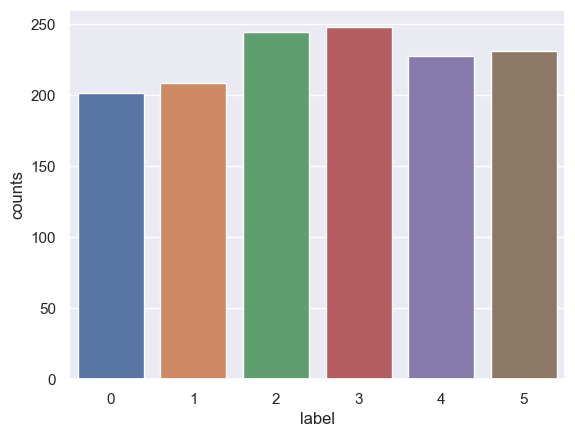

In [15]:
test_class_counts = test_df.groupby(by='label').count().reset_index()
test_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=test_class_counts) 

## Image preprocessing

In [16]:
train_X_norm = []
for image in train_X:
    image = image.astype('float64')
    image *= 255.0/image.max()
    image = image.astype('uint8')
    train_X_norm.append(image)

train_X_norm = np.array(train_X_norm)

val_X_norm = []
for image in val_X:
    image = image.astype('float64')
    image *= 255.0/image.max()
    image = image.astype('uint8')
    val_X_norm.append(image)

val_X_norm = np.array(val_X_norm)

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_X = normalization_layer(train_X)
normalized_val_X = normalization_layer(val_X)

2022-11-22 17:09:45.132934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(16,6))

bands = train_X.transpose(3, 0, 1, 2)
axes[0].set_title('band 0')
sns.histplot(np.random.choice(bands[0].ravel(), size=1000), ax=axes[0])
axes[1].set_title('band 1')
sns.histplot(np.random.choice(bands[1].ravel(), size=1000), ax=axes[1])
axes[2].set_title('band 2')
sns.histplot(np.random.choice(bands[2].ravel(), size=1000), ax=axes[2])

plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(16,6))

bands = train_X_norm.transpose(3, 0, 1, 2)
axes[0].set_title('band 0')
sns.histplot(np.random.choice(bands[0].ravel(), size=1000), ax=axes[0])
axes[1].set_title('band 1')
sns.histplot(np.random.choice(bands[1].ravel(), size=1000), ax=axes[1])
axes[2].set_title('band 2')
sns.histplot(np.random.choice(bands[2].ravel(), size=1000), ax=axes[2])

plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

axes[0].imshow(train_X[0])
axes[1].imshow(train_X_norm[0])

## Train Model

### Train Feed Forward Network

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()
    for layer_size in hidden_layer_sizes:
        
        model.add(keras.layers.Dense(
          units=layer_size,
          activation=activation,
        ))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
    ))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) if optimizer == 'SGD' \
             else tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model

In [ ]:
model = build_model(n_classes=len(classes),
                      hidden_layer_sizes=[150],
                      activation='relu',
                      optimizer='Adam',
                      learning_rate=.0005)

In [ ]:
print('Training...')
n_epochs = 20
history = model.fit(
    x=train_X,
    y=train_Y,
    epochs=n_epochs,
    batch_size=16,
    validation_data=(val_X, val_Y),
    # validation_split=0.10,
    verbose=True)

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(n_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

model_eval = model.evaluate(x=test_X, y=test_Y, verbose=0,
                             return_dict=True)

test_accuracy = model_eval['accuracy']
print(test_accuracy)

In [ ]:
predictions = model.predict(test_X)

In [ ]:
predictions[0].max()
guess = np.where(predictions[0]==predictions[0].max())

labels[guess[0][0]]

In [ ]:
def view_predictions(samples, actual, predictions, n_samples=5):
    fig, axes = plt.subplots(nrows=n_samples, ncols=1)
    fig.set_size_inches(10, 25)
    for i in range(n_samples):
        scores = predictions[i]
        guess = np.where(scores==scores.max())
        axes[i].imshow(samples[i])
        axes[i].set_title('ACTUAL: '+str(labels[actual[i]])+ 
                    ' PRED: '+str(labels[guess[0][0]]))
        
    plt.show()


In [ ]:
view_predictions(test_X, test_Y, predictions)

### Train 2d CNN

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_X = normalization_layer(train_X)
normalized_val_X = normalization_layer(val_X)
normalized_test_X = normalization_layer(test_X)

In [19]:
def build_2d_cnn_model(n_classes, input_shape,
                filters=32,
                strieds=1,
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                padding='valid',
                pool_size=2,
                kernel_sizes=[3]):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()

    for kernel_size in kernel_sizes:
      model.add(keras.layers.Conv2D(filters,kernel_size,input_shape=input_shape,padding=padding))
      model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
      model.add(keras.layers.Dropout(.5))
      
    model.add(keras.layers.Flatten())
    
    # model.add(keras.layers.Dense(16, activation=activation))
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
    ))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) if optimizer == 'SGD' \
             else tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model

In [22]:
def build_2d_cnn_model2(n_classes, input_shape,
                optimizer='SGD',
                learning_rate=0.01,
                padding='valid',
                pool_size=2):
    """Build a multi-class 2D CNN using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    input_shape: The shape of the input dataset.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=input_shape),
      keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Dropout(rate=0.5),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(n_classes),
    ])
    
    # model.add(keras.layers.Dense(16, activation=activation))
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
    ))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) if optimizer == 'SGD' \
             else tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model


In [20]:

input_shape = normalized_train_X.shape[1:]
model = build_2d_cnn_model(n_classes=len(classes),
                      input_shape=input_shape,
                      kernel_sizes=[5],
                      activation='relu',
                      optimizer='Adam',
                      learning_rate=.0005)

In [29]:

input_shape = normalized_train_X.shape[1:]
model = build_2d_cnn_model2(n_classes=len(classes),
                      input_shape=input_shape,
                      optimizer='Adam',
                      learning_rate=.00005)

In [30]:
print('Training...')
n_epochs = 70
history = model.fit(
    x=train_X,
    y=train_Y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(val_X, val_Y),
    # validation_split=0.10,
    verbose=True)

Training...
Epoch 1/70
384/384 [==============================] - 108s 279ms/step - loss: 1.2488 - accuracy: 0.5098 - val_loss: 0.9848 - val_accuracy: 0.6363
Epoch 2/70
384/384 [==============================] - 92s 238ms/step - loss: 0.9475 - accuracy: 0.6551 - val_loss: 0.8825 - val_accuracy: 0.6801
Epoch 3/70
384/384 [==============================] - 94s 245ms/step - loss: 0.8454 - accuracy: 0.6929 - val_loss: 0.7909 - val_accuracy: 0.7200
Epoch 4/70
384/384 [==============================] - 97s 251ms/step - loss: 0.7750 - accuracy: 0.7250 - val_loss: 0.7503 - val_accuracy: 0.7358
Epoch 5/70
384/384 [==============================] - 84s 218ms/step - loss: 0.7194 - accuracy: 0.7380 - val_loss: 0.7083 - val_accuracy: 0.7499
Epoch 6/70
384/384 [==============================] - 85s 223ms/step - loss: 0.6764 - accuracy: 0.7539 - val_loss: 0.7032 - val_accuracy: 0.7438
Epoch 7/70
384/384 [==============================] - 93s 241ms/step - loss: 0.6382 - accuracy: 0.7700 - val_loss: 0.

In [33]:
model.build()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

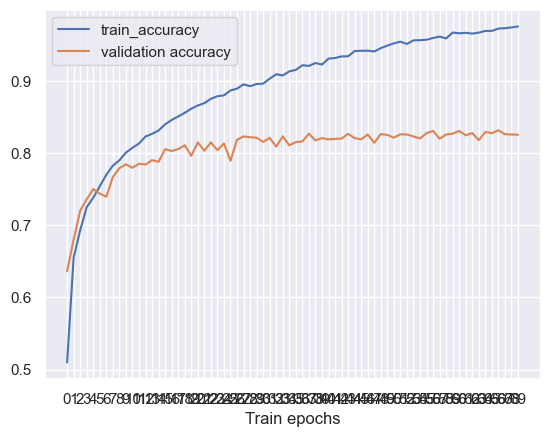

0.8121790289878845


In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(n_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

model_eval = model.evaluate(x=test_X, y=test_Y, verbose=0,
                             return_dict=True)

test_accuracy = model_eval['accuracy']
print(test_accuracy)